Feeding Script

In [33]:
#import necessary libraries 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.anova import AnovaRM
import pingouin as pg

Import and clean data

In [34]:
#Define the input path and output path
path = "./Data.xlsx"

#isolate the cumulative food intake by row/column
data = pd.read_excel(path, sheet_name=0, header=1)
data_vehicle = data.iloc[0:9, 0:6]
data_drug1 = data.iloc[13:22, 0:6]
data_drug2 = data.iloc[26:35, 0:6]

In [35]:
#concat dfs
all_data = pd.concat([data_vehicle, data_drug1, data_drug2])
#print(all_data) #uncomment to check

def melt(cohort):
    cohort_melt = pd.melt(cohort, id_vars=['Mouse', 'Condition'], value_vars=cohort.columns[2:], var_name='Time', value_name='Grams')
    cohort_melt['Time'] = pd.to_numeric(cohort_melt['Time'])
    cohort_melt['Grams'] = pd.to_numeric(cohort_melt['Grams'])
    return cohort_melt
    #check the type of each variable 
    #print(cohort_melt.dtypes) #uncomment to check

all_data = melt(all_data)

Run statistical analyses 

Two way repeated measures anova for within subject analyses

In [36]:
#Two way RM ANOVA
anova_results = (AnovaRM(data=all_data, depvar='Grams', subject='Mouse',within=['Condition', 'Time'])).fit()
print(anova_results)

                    Anova
               F Value  Num DF  Den DF Pr > F
---------------------------------------------
Condition       14.3043 2.0000 16.0000 0.0003
Time           169.2139 3.0000 24.0000 0.0000
Condition:Time   6.0935 6.0000 48.0000 0.0001



Post hoc analysis using pairwise tests

In [37]:
post_hoc_results = []

#loops through all time points
for time in all_data['Time'].unique():
    subset = all_data[all_data['Time']== time]
    result = pg.pairwise_tests(data=subset, dv='Grams', within='Condition', subject='Mouse', padjust='bonf', effsize='cohen')
    result['Time'] = time
    post_hoc_results.append(result)

#combine into data frame for easier viewing 
post_hoc_df = pd.concat(post_hoc_results, ignore_index= True)

#print(post_hoc_df.head()) #uncomment to view
#export post_hoc to excel
post_hoc_df.to_excel('./Results/post_hoc_results.xlsx')

In [38]:
#filter for signficant p values
sig_values = post_hoc_df[post_hoc_df['p-corr'] < 0.05]
sig_values

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen,Time
1,Condition,Drug_1,Vehicle,True,True,-3.652008,8.0,two-sided,0.006476,0.019427,bonf,8.993,-1.471898,0.5
2,Condition,Drug_2,Vehicle,True,True,-4.000000,8.0,two-sided,0.003950,0.011849,bonf,13.389,-1.314920,0.5
4,Condition,Drug_1,Vehicle,True,True,-4.244972,8.0,two-sided,0.002818,0.008455,bonf,17.604,-2.508293,1.0
5,Condition,Drug_2,Vehicle,True,True,-3.830192,8.0,two-sided,0.005017,0.015050,bonf,11.04,-1.665657,1.0
7,Condition,Drug_1,Vehicle,True,True,-7.405548,8.0,two-sided,0.000076,0.000227,bonf,355.54,-3.300241,2.0
8,Condition,Drug_2,Vehicle,True,True,-3.918672,8.0,two-sided,0.004427,0.013280,bonf,12.211,-1.790700,2.0
10,Condition,Drug_1,Vehicle,True,True,-5.051147,8.0,two-sided,0.000988,0.002964,bonf,41.553,-2.779922,4.0
11,Condition,Drug_2,Vehicle,True,True,-3.582153,8.0,two-sided,0.007166,0.021497,bonf,8.292,-1.825944,4.0


In [39]:
#convert pvalues to asterisks
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

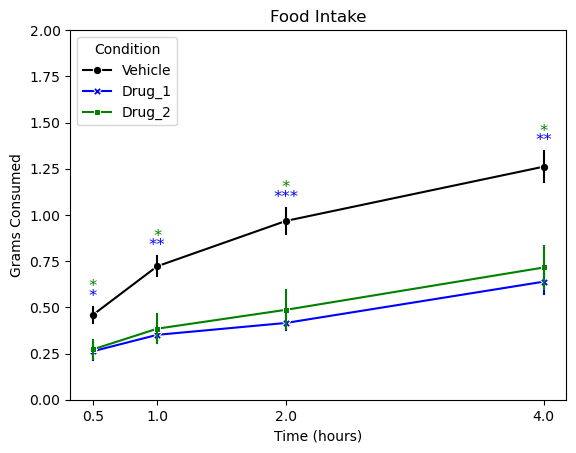

In [40]:

#determine x values
x_values = all_data['Time'].unique()
x_values
    
#Create line plot
sns.lineplot(data=all_data, x='Time', y='Grams', hue='Condition',
             style='Condition', palette=line_colors,
             errorbar='se', err_style='bars', markers=True, dashes=False)
plt.ylim(0, 2.0)
plt.xticks(x_values)
plt.xlabel('Time (hours)')
plt.ylabel('Grams Consumed')
plt.title('Food Intake')

# Loop through significant results and annotate
for _, row in sig_values.iterrows():
    time = row['Time']
    cond1 = row['A']
    cond2 = row['B']
    pval = row['p-corr']
    asterisk = convert_pvalue_to_asterisks(pval)

    # Find max y at this timepoint for these two conditions
    vehicle_subset = all_data[(all_data['Time'] == time) & (all_data['Condition'] == 'Vehicle')]
    mean_vehicle = vehicle_subset['Grams'].mean()
    se_vehicle = vehicle_subset['Grams'].sem()
    y_position = mean_vehicle + se_vehicle + 0.02  # buffer above error bar
    #determine the color asterick
    if cond1 == 'Drug_1':
        as_color = 'blue'
        y_position = y_position
    elif cond1 == 'Drug_2':
        as_color = 'green'
        y_position = y_position + 0.05
    # Slightly offset the line and text
    y_offset = 0.05

    # Add astericks
    #plt.plot([time, time], [max_y + y_offset, max_y + y_offset + 0.02], color='k')
    plt.text(time, y_position, asterisk, ha='center', va='bottom', fontsize=12, color = as_color)
plt.savefig('./Results/graph.pdf')
plt.show()
